# Alzheimer's Disease Multimodal Detection - Phase 1: Image Classification

This notebook handles MRI brain scan classification with the following features:
- Data loading and exploration
- Class balancing (handling imbalanced dataset)
- Data augmentation to increase dataset size
- Train/Test/Val split
- Multiple CNN architectures comparison
- XAI integration (Grad-CAM)
- Model evaluation and comparison
- **Model saving for Flask web application**

## Dataset Structure Expected:
- 4 Classes: NonDemented, VeryMildDemented, MildDemented, ModerateDemented
- Format: Folders with images in JPG/PNG format
- Location: Update `DATA_PATH` in Cell 1 to point to your `OriginalDataset` folder

## Important Notes:
1. **Update DATA_PATH**: Change the path in Cell 1 to match your local dataset location
2. **Model Saving**: After training, the best model is automatically saved to `models/best_model.h5` for use with the Flask app
3. **XAI**: Grad-CAM visualizations are generated to show which brain regions influence predictions
4. **LLM**: Natural language explanations are generated (requires OpenAI API key for best results)

In [ ]:
#Install required libraries (run this first in Colab)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import cv2
import zipfile
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Your exact dataset path
# For local use, update this to your dataset location
# Example: DATA_PATH = './OriginalDataset' or DATA_PATH = r'D:\Capstone\OriginalDataset'
DATA_PATH = './OriginalDataset'  # Change this to match your local path

# Configuration variables
IMG_SIZE = (176, 208)
TARGET_SIZE = (96, 96)
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 0.001
PATIENCE = 10
AUGMENTATION_FACTOR = 3
CLASSES = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
TEST_SIZE = 0.2
VAL_SIZE = 0.2

print(f"\n📁 Dataset Path: {DATA_PATH}")


📁 Dataset Path: /kaggle/input/alzheimers/OriginalDataset


# PART 3: VERIFY DATASET STRUCTURE


In [26]:
if not os.path.exists(DATA_PATH):
    print(f" ERROR: Path does not exist: {DATA_PATH}")
    print("\nChecking what's inside BASE_DATA_DIR:")
    print(os.listdir(BASE_DATA_DIR))
else:
    print(f"\n Dataset Path exists: {DATA_PATH}")
    print("\nFolder Structure:")

    for class_name in CLASSES:
        class_path = os.path.join(DATA_PATH, class_name)
        if os.path.exists(class_path):
            num_images = len([f for f in os.listdir(class_path)
                            if f.endswith(('.jpg', '.png', '.jpeg'))])
            print(f" {class_name}: {num_images} images")
        else:
            print(f" {class_name}: Folder not found!")


 Dataset Path exists: /kaggle/input/alzheimers/OriginalDataset

Folder Structure:
 NonDemented: 3200 images
 VeryMildDemented: 2240 images
 MildDemented: 896 images
 ModerateDemented: 64 images


# PART 4: LOAD AND EXPLORE DATA


Total images found: 6400

Class Distribution:
label
NonDemented         3200
VeryMildDemented    2240
MildDemented         896
ModerateDemented      64
Name: count, dtype: int64


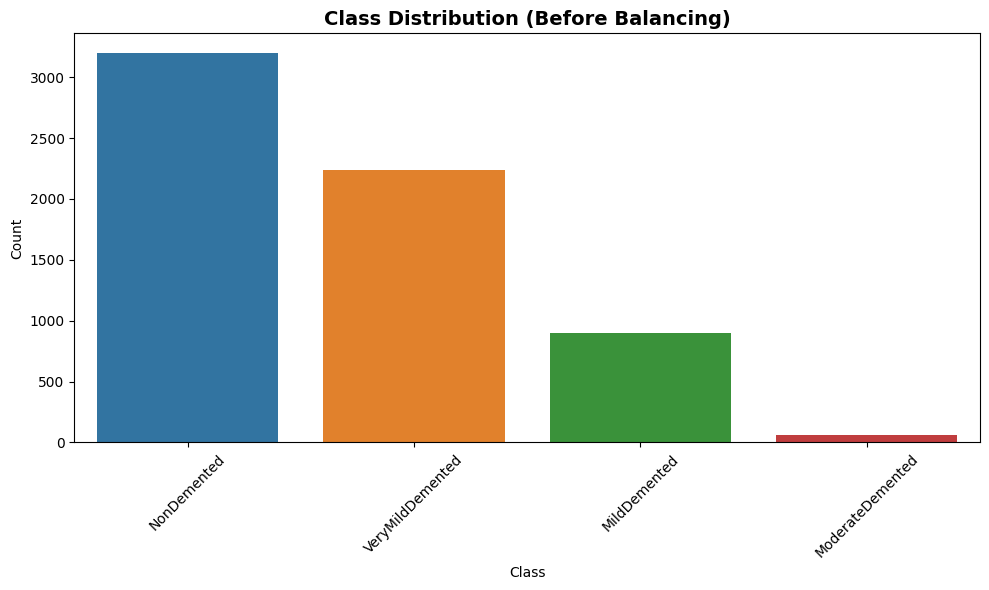

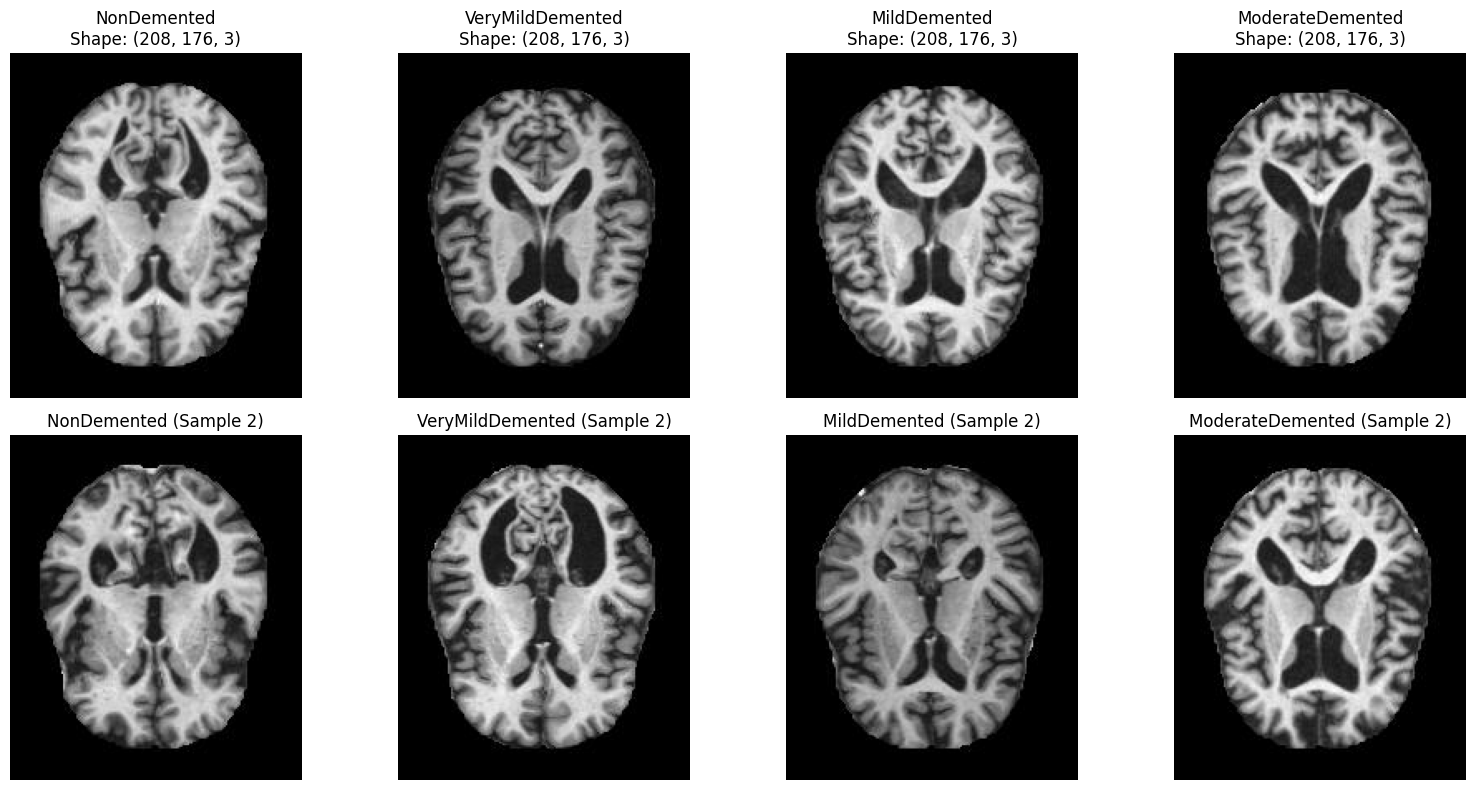

In [28]:
image_paths = []
labels = []

# Load all image paths and labels
for class_name in CLASSES:
    class_path = os.path.join(DATA_PATH, class_name)
    if os.path.exists(class_path):
        for img_name in os.listdir(class_path):
            if img_name.endswith(('.jpg', '.png', '.jpeg')):
                image_paths.append(os.path.join(class_path, img_name))
                labels.append(class_name)

# Create DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

print(f"\nTotal images found: {len(df)}")
print("\nClass Distribution:")
print(df['label'].value_counts())

# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label', order=CLASSES)
plt.title('Class Distribution (Before Balancing)', fontsize=14, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show sample images from each class
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for idx, class_name in enumerate(CLASSES):
    class_df = df[df['label'] == class_name]
    if len(class_df) > 0:
        # First sample
        sample_path = class_df.iloc[0]['image_path']
        img = cv2.imread(sample_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(img)
        axes[idx].set_title(f'{class_name}\nShape: {img.shape}')
        axes[idx].axis('off')

        # Second sample
        if len(class_df) > 1:
            sample_path2 = class_df.iloc[1]['image_path']
            img2 = cv2.imread(sample_path2)
            img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
            axes[idx + 4].imshow(img2)
            axes[idx + 4].set_title(f'{class_name} (Sample 2)')
            axes[idx + 4].axis('off')

plt.tight_layout()
plt.show()


# PART 5: DATA BALANCING AND AUGMENTATION


Target count per class: 9600

NonDemented:
  Current: 3200
  Needed: 6400

VeryMildDemented:
  Current: 2240
  Needed: 7360

MildDemented:
  Current: 896
  Needed: 8704

ModerateDemented:
  Current: 64
  Needed: 9536

--------------------------------------------------------------------------------
After Augmentation:
label
NonDemented         10666
VeryMildDemented    10000
MildDemented         9625
ModerateDemented     9600
Name: count, dtype: int64


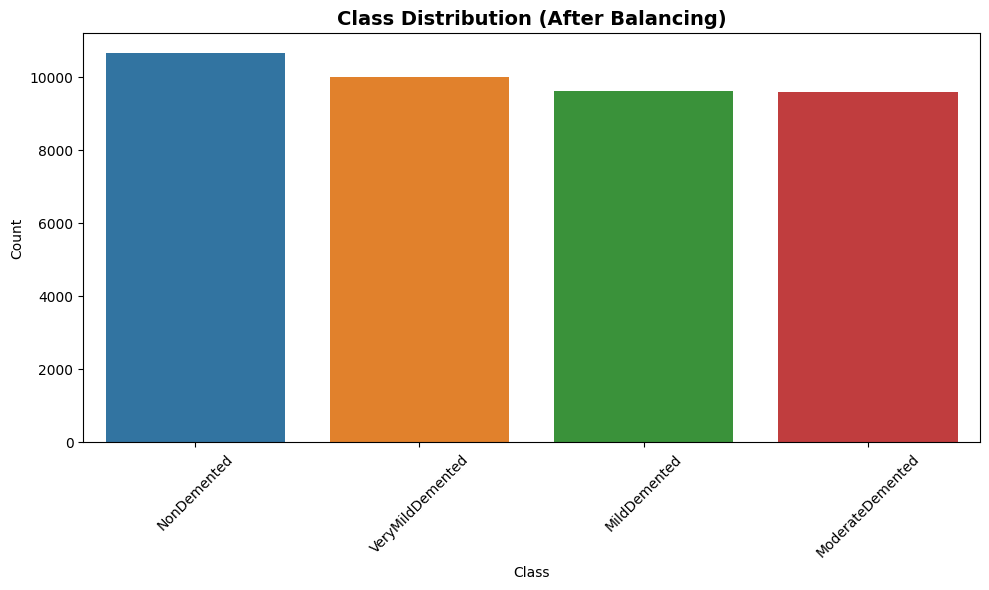

In [29]:
# Find the maximum class count
class_counts = df['label'].value_counts()
max_count = class_counts.max()
target_count = max_count * AUGMENTATION_FACTOR

print(f"\nTarget count per class: {target_count}")

# Create augmentation generator
aug_generator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

augmented_data = []

for class_name in CLASSES:
    class_df = df[df['label'] == class_name]
    current_count = len(class_df)
    needed_count = target_count - current_count

    print(f"\n{class_name}:")
    print(f"  Current: {current_count}")
    print(f"  Needed: {needed_count}")

    # Add original images
    for _, row in class_df.iterrows():
        augmented_data.append({
            'image_path': row['image_path'],
            'label': class_name,
            'augmented': False
        })

    # Generate augmented images
    if needed_count > 0:
        augmented_per_image = needed_count // current_count + 1

        for idx, row in class_df.iterrows():
            img = cv2.imread(row['image_path'])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, TARGET_SIZE)
            img = img.reshape((1,) + img.shape)

            count = 0
            for batch in aug_generator.flow(img, batch_size=1):
                # FIX: Convert to proper numpy array
                aug_img = batch[0].astype('uint8')
                augmented_data.append({
                    'image_data': aug_img,  # Store as numpy array
                    'label': class_name,
                    'augmented': True
                })
                count += 1
                if count >= augmented_per_image:
                    break
                if len([d for d in augmented_data if d['label'] == class_name]) >= target_count:
                    break

augmented_df = pd.DataFrame(augmented_data)

print("\n" + "-"*80)
print("After Augmentation:")
print(augmented_df['label'].value_counts())

# Visualize balanced distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=augmented_df, x='label', order=CLASSES)
plt.title('Class Distribution (After Balancing)', fontsize=14, fontweight='bold')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# PART 6: PREPARE DATA FOR TRAINING

In [30]:
X = []
y = []
failed_count = 0

for idx, row in augmented_df.iterrows():
    try:
        if 'image_data' in row and row.get('augmented', False):
            # Augmented image already in memory
            img = row['image_data']
        else:
            # Load original image
            img = cv2.imread(row['image_path'])
            if img is None:
                print(f"  ⚠️ Warning: Could not read {row['image_path']}")
                failed_count += 1
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, TARGET_SIZE)

        # Verify image shape
        if img.shape != TARGET_SIZE + (3,):
            print(f"  ⚠️ Warning: Invalid shape {img.shape} at index {idx}")
            failed_count += 1
            continue

        X.append(img)
        y.append(CLASSES.index(row['label']))

        if (idx + 1) % 500 == 0:
            print(f"  Processed {idx + 1}/{len(augmented_df)} images")

    except Exception as e:
        print(f"  ⚠️ Error processing index {idx}: {e}")
        failed_count += 1
        continue

print(f"\n✅ Successfully processed: {len(X)} images")
print(f"❌ Failed: {failed_count} images")

# Convert to numpy arrays
X = np.array(X, dtype='float32') / 255.0  # Normalize
y = np.array(y)

print(f"\nData shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Memory usage: {X.nbytes / (1024**3):.2f} GB")

# Verify the data
print(f"\nData range: [{X.min():.3f}, {X.max():.3f}]")
print(f"Label distribution: {Counter(y)}")


  Processed 500/39891 images
  Processed 1000/39891 images
  Processed 1500/39891 images
  Processed 2000/39891 images
  Processed 2500/39891 images
  Processed 12000/39891 images
  Processed 12500/39891 images
  Processed 13000/39891 images
  Processed 13500/39891 images
  Processed 14000/39891 images
  Processed 14500/39891 images
  Processed 15000/39891 images
  Processed 15500/39891 images
  Processed 16000/39891 images
  Processed 16500/39891 images
  Processed 17000/39891 images
  Processed 17500/39891 images
  Processed 18000/39891 images
  Processed 18500/39891 images
  Processed 19000/39891 images
  Processed 19500/39891 images
  Processed 20000/39891 images
  Processed 20500/39891 images
  Processed 21000/39891 images
  Processed 21500/39891 images
  Processed 22000/39891 images
  Processed 22500/39891 images
  Processed 23000/39891 images
  Processed 23500/39891 images
  Processed 24000/39891 images
  Processed 24500/39891 images
  Processed 25000/39891 images
  Processed 25

# PART 7: TRAIN/TEST/VAL SPLIT


In [31]:
from sklearn.model_selection import train_test_split
from collections import Counter

# Define your features and target
# Example: If you have a DataFrame called 'df' with features and a target column
# X = df.drop('target_column_name', axis=1)  # Features
# y = df['target_column_name']  # Target variable

# OR if you have them in a different format:
# X = your_features_array
# y = your_target_array

# Define split sizes
TEST_SIZE = 0.2    # 20% for test set
VAL_SIZE = 0.2     # 20% of remaining data for validation set

# First split: train+val and test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=42, stratify=y
)

# Second split: train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=VAL_SIZE, random_state=42, stratify=y_temp
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

print("\nTrain set distribution:", Counter(y_train))
print("Val set distribution:", Counter(y_val))
print("Test set distribution:", Counter(y_test))


Train set: 25529 samples
Validation set: 6383 samples
Test set: 7979 samples

Train set distribution: Counter({0: 6825, 1: 6400, 2: 6160, 3: 6144})
Val set distribution: Counter({0: 1707, 1: 1600, 2: 1540, 3: 1536})
Test set distribution: Counter({0: 2134, 1: 2000, 2: 1925, 3: 1920})


# PART 8: MODEL 1 - CUSTOM CNN

Model: "CustomCNN_Regularized"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 96, 96, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 323,876 (1.24 MB)

 Trainable params: 322,468 (1.23 MB)

 Non-trainable params: 1,408 (5.50 KB)


Training Regularized Custom CNN...
Epoch 1/50
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 73s 39ms/step - accuracy: 0.4338 - loss: 1.3356 - val_accuracy: 0.4326 - val_loss: 1.3314 - learning_rate: 0.0010
Epoch 2/50
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 54s 34ms/step - accuracy: 0.6147 - loss: 0.8645 - val_accuracy: 0.3740 - val_loss: 1.8469 - learning_rate: 0.0010
Epoch 3/50
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 54s 34ms/step - accuracy: 0.6591 - loss: 0.7694 - val_accuracy: 0.6135 - val_loss: 0.9053 - learning_rate: 0.0010
Epoch 4/50
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 54s 34ms/step - accuracy: 0.6876 - loss: 0.7147 - val_accuracy: 0.6759 - val_loss: 0.6899 - learning_rate: 0.0010
Epoch 5/50
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 53s 33ms/step - accuracy: 0.7057 - loss: 0.6802 - val_accuracy: 0.6672 - val_loss: 0.6848 - learning_rate: 0.0010
Epoch 6/50
1596/1596 ━━━━━━━━━━━━━━━━━━━━ 53s 33ms/step - accuracy: 0.7309 - loss: 0.6278 - val_accuracy: 0.7246 - val_loss: 0.6561 - learning_rate: 0.0010
Epoch 7/50
1596/1596 ━━━━━━━

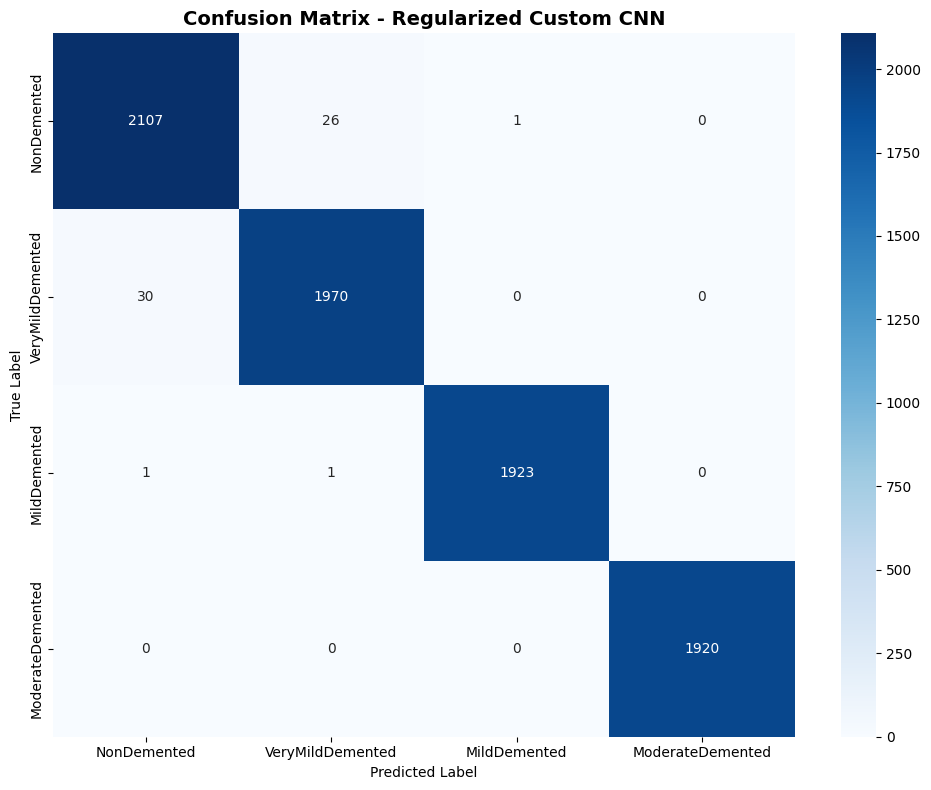

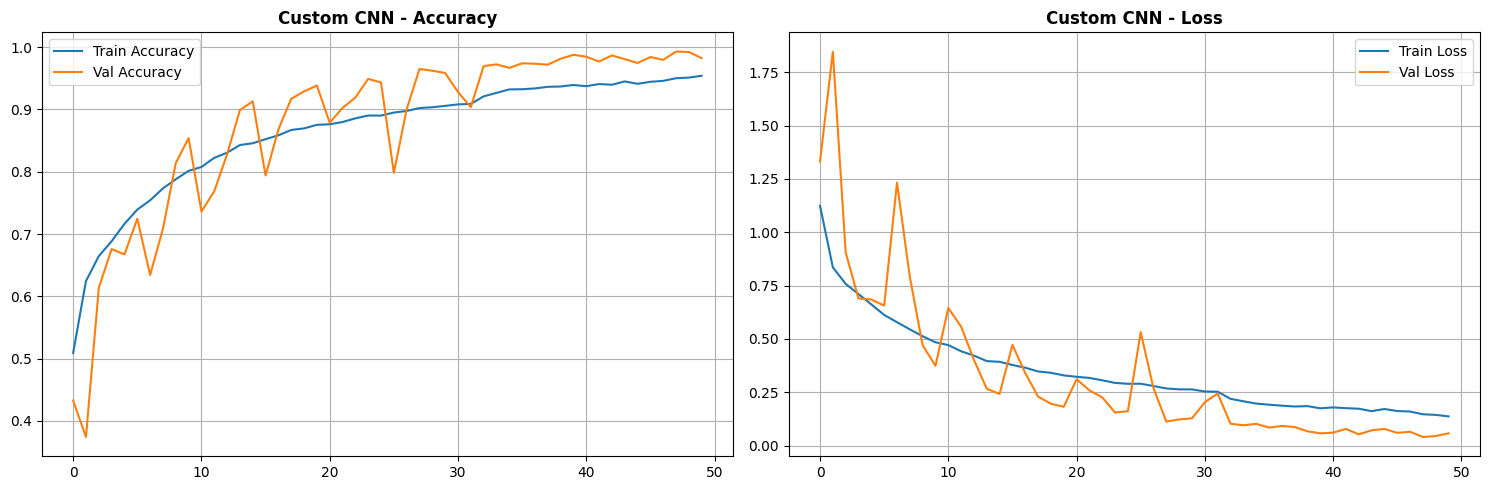

In [32]:
# --- Model Architecture (Improved for Generalization) ---
input_shape = (96, 96, 3)
num_classes = len(CLASSES)

model_custom = keras.Sequential([
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
], name='CustomCNN_Regularized')

model_custom.summary()

# --- Compilation ---
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model_custom.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# --- Callbacks ---
callbacks_custom = [
    EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6),
    ModelCheckpoint('CustomCNN_best.h5', monitor='val_accuracy', save_best_only=True)
]

# --- Data Augmentation (to further prevent overfitting) ---
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# --- Training ---
print("\nTraining Regularized Custom CNN...")
history_custom = model_custom.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    callbacks=callbacks_custom,
    verbose=1
)

# --- Evaluation ---
train_loss_custom, train_acc_custom = model_custom.evaluate(X_train, y_train, verbose=0)
test_loss_custom, test_acc_custom = model_custom.evaluate(X_test, y_test, verbose=0)

print(f"\nCustom CNN Results:")
print(f"  Train Accuracy: {train_acc_custom:.4f}")
print(f"  Test Accuracy: {test_acc_custom:.4f}")

# --- Predictions ---
y_pred_custom = np.argmax(model_custom.predict(X_test), axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_custom, target_names=CLASSES))

# --- Confusion Matrix ---
cm_custom = confusion_matrix(y_test, y_pred_custom)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_custom, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix - Regularized Custom CNN', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# --- Training History ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history_custom.history['accuracy'], label='Train Accuracy')
ax1.plot(history_custom.history['val_accuracy'], label='Val Accuracy')
ax1.set_title('Custom CNN - Accuracy', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True)

ax2.plot(history_custom.history['loss'], label='Train Loss')
ax2.plot(history_custom.history['val_loss'], label='Val Loss')
ax2.set_title('Custom CNN - Loss', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


# PART 9: MODEL 2 - VGG16 (Transfer Learning)


Class weights: {0: 0.9351282051282052, 1: 0.9972265625, 2: 1.0360795454545455, 3: 1.0387776692708333}

STAGE 1: Training top layers with frozen VGG16 base
Trainable parameters: 397,060
Epoch 1/30
798/798 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - accuracy: 0.4840 - loss: 1.9928 - val_accuracy: 0.6815 - val_loss: 1.2451 - learning_rate: 0.0010
Epoch 2/30
798/798 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6407 - loss: 1.2946 - val_accuracy: 0.7108 - val_loss: 1.0341 - learning_rate: 0.0010
Epoch 3/30
798/798 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6628 - loss: 1.1195 - val_accuracy: 0.7160 - val_loss: 0.9370 - learning_rate: 0.0010
Epoch 4/30
798/798 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6774 - loss: 1.0208 - val_accuracy: 0.7214 - val_loss: 0.9073 - learning_rate: 0.0010
Epoch 5/30
798/798 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.6757 - loss: 1.0063 - val_accuracy: 0.7288 - val_loss: 0.8936 - learning_rate: 0.0010
Epoch 6/30
798/798 ━━━━━━━━━━━━━━━━━━━━ 19s 2

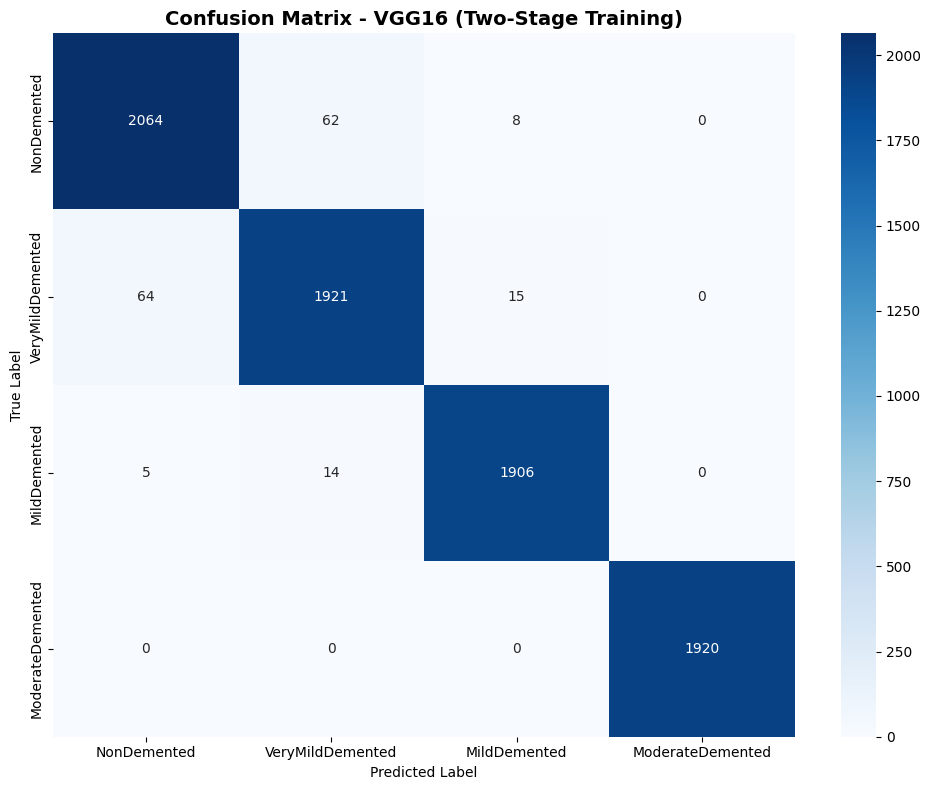

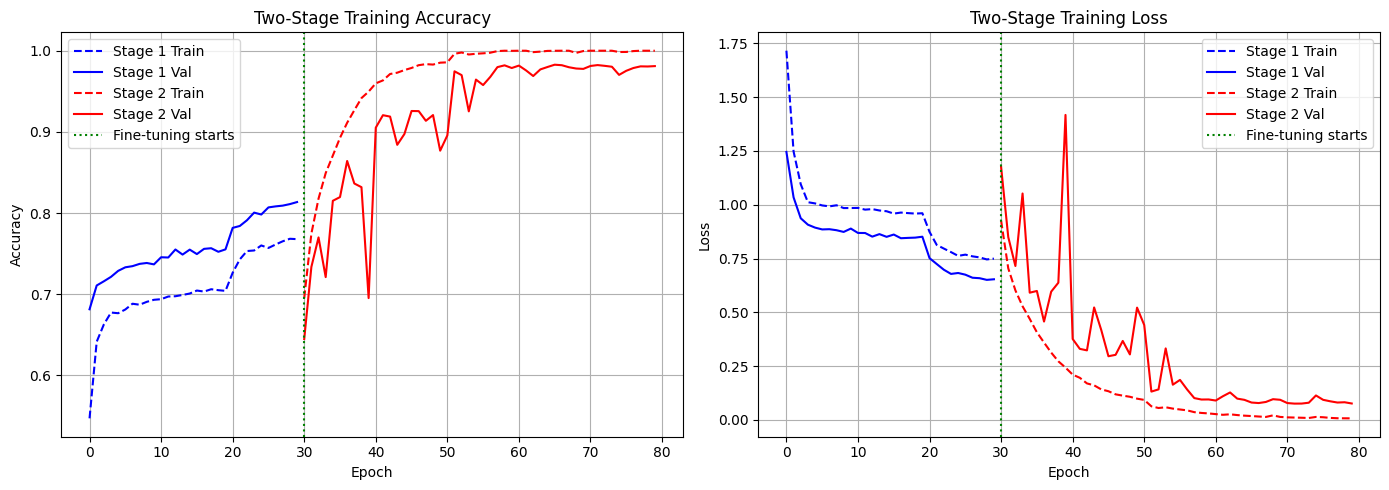

In [33]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Define constants
input_shape = (96, 96, 3)  
num_classes = 4 

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")

# ============= STAGE 1: Train only the top layers =============
print("\n" + "="*60)
print("STAGE 1: Training top layers with frozen VGG16 base")
print("="*60)

base_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
base_vgg16.trainable = False  # Freeze all base layers

model_vgg16 = models.Sequential([
    base_vgg16,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
], name='VGG16')

model_vgg16.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Trainable parameters: {sum([np.prod(w.shape) for w in model_vgg16.trainable_weights]):,}")

callbacks_stage1 = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
]

history_stage1 = model_vgg16.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=callbacks_stage1,
    class_weight=class_weight_dict,
    verbose=1
)

# Evaluate after stage 1
val_loss_s1, val_acc_s1 = model_vgg16.evaluate(X_val, y_val, verbose=0)
print(f"\nStage 1 Results - Val Accuracy: {val_acc_s1:.4f}")

# ============= STAGE 2: Fine-tune the last layers =============

# Unfreeze the last 4 layers of VGG16
base_vgg16.trainable = True
for layer in base_vgg16.layers[:-4]:
    layer.trainable = False

# Recompile with lower learning rate for fine-tuning
model_vgg16.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Lower LR
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Trainable parameters: {sum([np.prod(w.shape) for w in model_vgg16.trainable_weights]):,}")

callbacks_stage2 = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-8, verbose=1),
    ModelCheckpoint('VGG16_best.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

history_stage2 = model_vgg16.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks_stage2,
    class_weight=class_weight_dict,
    verbose=1
)

# ============= Final Evaluation =============
print("\n" + "="*60)
print("FINAL EVALUATION")
print("="*60)

test_loss_vgg16, test_acc_vgg16 = model_vgg16.evaluate(X_test, y_test, verbose=0)
train_loss_vgg16, train_acc_vgg16 = model_vgg16.evaluate(X_train, y_train, verbose=0)

print(f"\nVGG16 Final Results:")
print(f"  Train Accuracy: {train_acc_vgg16:.4f}")
print(f"  Test Accuracy: {test_acc_vgg16:.4f}")

y_pred_vgg16 = np.argmax(model_vgg16.predict(X_test), axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_vgg16, target_names=CLASSES))

# Confusion matrix
cm_vgg16 = confusion_matrix(y_test, y_pred_vgg16)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_vgg16, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix - VGG16 (Two-Stage Training)', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Plot combined training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_stage1.history['accuracy'], label='Stage 1 Train', color='blue', linestyle='--')
plt.plot(history_stage1.history['val_accuracy'], label='Stage 1 Val', color='blue')
offset = len(history_stage1.history['accuracy'])
plt.plot(range(offset, offset + len(history_stage2.history['accuracy'])), 
         history_stage2.history['accuracy'], label='Stage 2 Train', color='red', linestyle='--')
plt.plot(range(offset, offset + len(history_stage2.history['val_accuracy'])), 
         history_stage2.history['val_accuracy'], label='Stage 2 Val', color='red')
plt.axvline(x=offset, color='green', linestyle=':', label='Fine-tuning starts')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Two-Stage Training Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_stage1.history['loss'], label='Stage 1 Train', color='blue', linestyle='--')
plt.plot(history_stage1.history['val_loss'], label='Stage 1 Val', color='blue')
plt.plot(range(offset, offset + len(history_stage2.history['loss'])), 
         history_stage2.history['loss'], label='Stage 2 Train', color='red', linestyle='--')
plt.plot(range(offset, offset + len(history_stage2.history['val_loss'])), 
         history_stage2.history['val_loss'], label='Stage 2 Val', color='red')
plt.axvline(x=offset, color='green', linestyle=':', label='Fine-tuning starts')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Two-Stage Training Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# PART 10: MODEL 3 - ResNet50 (Transfer Learning)

In [ ]:
"""base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
base_resnet.trainable = False

model_resnet = models.Sequential([
    base_resnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
], name='ResNet50')

model_resnet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_resnet = [
    EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),
    ModelCheckpoint('ResNet50_best.h5', monitor='val_accuracy', save_best_only=True)
]

print("\nTraining ResNet50...")
history_resnet = model_resnet.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks_resnet,
    verbose=1
)

# Evaluate
test_loss_resnet, test_acc_resnet = model_resnet.evaluate(X_test, y_test, verbose=0)
train_loss_resnet, train_acc_resnet = model_resnet.evaluate(X_train, y_train, verbose=0)

print(f"\nResNet50 Results:")
print(f"  Train Accuracy: {train_acc_resnet:.4f}")
print(f"  Test Accuracy: {test_acc_resnet:.4f}")

y_pred_resnet = np.argmax(model_resnet.predict(X_test), axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_resnet, target_names=CLASSES))

# Confusion matrix
cm_resnet = confusion_matrix(y_test, y_pred_resnet)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix - ResNet50', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show() """

# PART 13: MODEL COMPARISON


     Model  Train Accuracy  Test Accuracy  Test Loss
CustomCNN         0.99667       0.992606   0.042201
    VGG16         1.00000       0.978945   0.086357


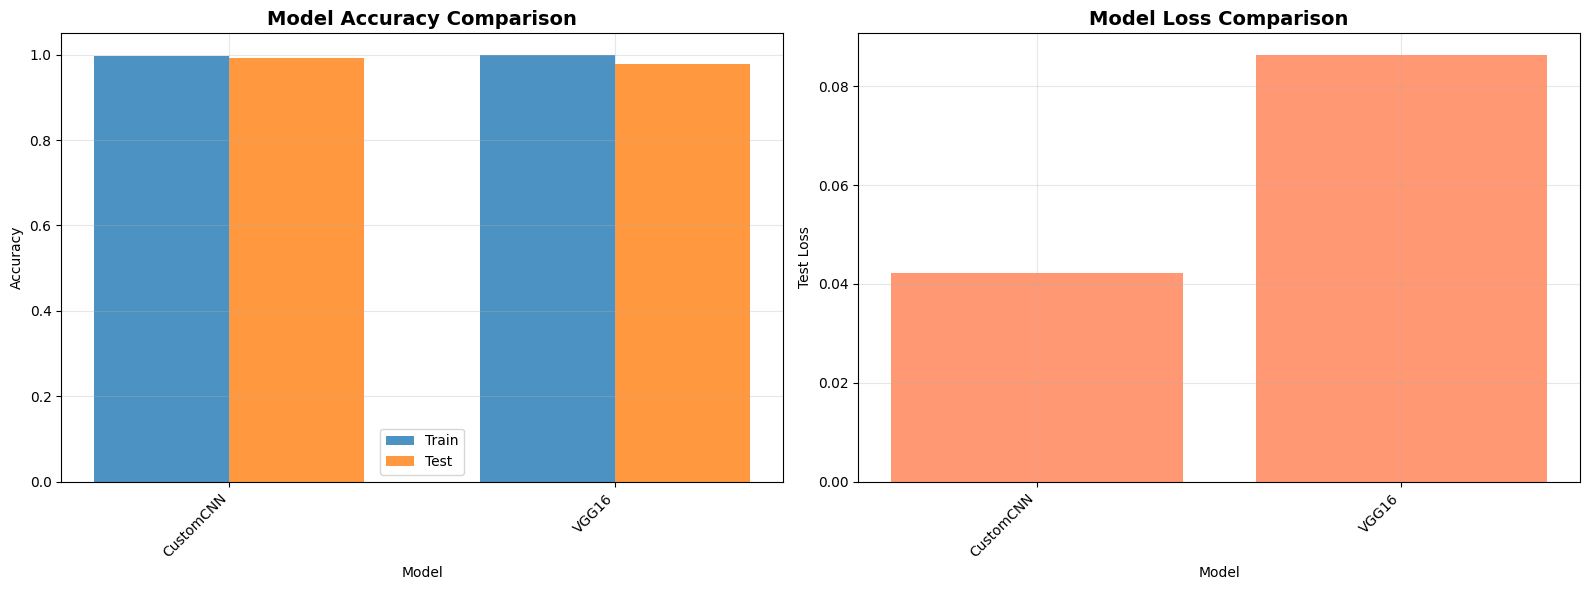


BEST MODEL: CustomCNN
Test Accuracy: 0.9926


In [ ]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': ['CustomCNN', 'VGG16'],
    'Train Accuracy': [train_acc_custom, train_acc_vgg16],
    'Test Accuracy': [test_acc_custom, test_acc_vgg16],
    'Test Loss': [test_loss_custom, test_loss_vgg16]
})

comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)
print("\n", comparison_df.to_string(index=False))

# Visualize comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

x = np.arange(len(comparison_df))
width = 0.35

ax1.bar(x - width/2, comparison_df['Train Accuracy'], width, label='Train', alpha=0.8)
ax1.bar(x + width/2, comparison_df['Test Accuracy'], width, label='Test', alpha=0.8)
ax1.set_xlabel('Model')
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.bar(comparison_df['Model'], comparison_df['Test Loss'], alpha=0.8, color='coral')
ax2.set_xlabel('Model')
ax2.set_ylabel('Test Loss')
ax2.set_title('Model Loss Comparison', fontsize=14, fontweight='bold')
ax2.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

best_model_name = comparison_df.iloc[0]['Model']
print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model_name}")
print(f"Test Accuracy: {comparison_df.iloc[0]['Test Accuracy']:.4f}")
print(f"{'='*80}")

# Save comparison results
comparison_df.to_csv('model_comparison_results.csv', index=False)

# Determine best model object
if best_model_name == 'CustomCNN':
    best_model = model_custom
elif best_model_name == 'VGG16':
    best_model = model_vgg16

# Save the best model for Flask app
import os
os.makedirs('models', exist_ok=True)
best_model.save('models/best_model.h5')
print(f"\n✅ Best model saved to: models/best_model.h5")
print("   This model will be used by the Flask web application.")

# XAI utilities

In [76]:
!pip install shap transformers[sentencepiece] openai --quiet

In [80]:
import numpy as np

# If your validation data is in X_val and y_val
test_images = X_val
test_labels = y_val

# (Optional) Take a smaller subset to save memory
num_collect = min(100, len(test_images))
test_images = test_images[:num_collect]
test_labels = test_labels[:num_collect]

print("✅ Collected test_images shape:", test_images.shape)
print("✅ Collected test_labels shape:", test_labels.shape)


✅ Collected test_images shape: (100, 96, 96, 3)
✅ Collected test_labels shape: (100,)


In [90]:
# ✅ Build the model by running one prediction
_ = model_custom.predict(X_val[:1])
print(_)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
[[0.01484203 0.02140726 0.9637508  0.        ]]


In [91]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# ✅ Use your trained model here
model = model_custom  # change if needed

# Pick last convolutional layer automatically
last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

if last_conv_layer_name is None:
    raise ValueError("No Conv2D layer found in model!")

print(f"Using last conv layer: {last_conv_layer_name}")

# Grad-CAM function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        predicted_class = tf.argmax(predictions[0])
        loss = predictions[:, predicted_class]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-8)
    return heatmap.numpy()

# Take one or a few test images
sample_images = test_images[:3]

for idx, img in enumerate(sample_images):
    img_input = np.expand_dims(img, axis=0)

    heatmap = make_gradcam_heatmap(img_input, model, last_conv_layer_name)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed = cv2.addWeighted(
        np.uint8(255 * img), 0.6, heatmap_color, 0.4, 0
    )

    plt.figure(figsize=(6, 6))
    plt.imshow(superimposed)
    plt.axis("off")
    plt.title(f"Grad-CAM for Test Image {idx+1}")
    plt.show()

Using last conv layer: conv2d_15


AttributeError: The layer CustomCNN_Regularized has never been called and thus has no defined output.

# LLM Summary Generation

In [ ]:
# Enhanced LLM Summary Generation (Fixed Version)
# This demonstrates how the Flask app generates explanations

import os

# Example: Generate explanation for a sample prediction
sample_idx = 0
sample_img = test_images[sample_idx:sample_idx+1]
sample_label = test_labels[sample_idx]

# Make prediction
prediction = best_model.predict(sample_img, verbose=0)
predicted_class_idx = np.argmax(prediction[0])
predicted_class = CLASSES[predicted_class_idx]
confidence = prediction[0][predicted_class_idx]

# Get all probabilities
all_probs = {CLASSES[i]: float(prediction[0][i]) for i in range(len(CLASSES))}

# Create summary prompt
summary_prompt = f"""You are a medical AI assistant explaining Alzheimer's disease MRI scan classification results.

Prediction Results:
- Predicted Class: {predicted_class}
- Confidence: {confidence*100:.1f}%
- All Class Probabilities:
{chr(10).join([f'- {cls}: {prob*100:.1f}%' for cls, prob in sorted(all_probs.items(), key=lambda x: x[1], reverse=True)])}

Model Performance:
- Test Accuracy: {comparison_df.iloc[0]['Test Accuracy']*100:.2f}%
- Best Model: {best_model_name}

The Grad-CAM heatmap visualization shows which brain regions influenced this prediction. 
Explain what this prediction means and how the model's performance supports its reliability.
"""

# Try OpenAI API first, fallback to local model
try:
    from openai import OpenAI
    
    if "OPENAI_API_KEY" in os.environ:
        client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])
        completion = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are a medical AI assistant explaining MRI scan results."},
                {"role": "user", "content": summary_prompt},
            ],
            max_tokens=200
        )
        print("🔹 LLM Summary (via OpenAI):\n")
        print(completion.choices[0].message.content)
    else:
        raise ImportError("OpenAI API key not found")
except Exception as e:
    print(f"⚠️ OpenAI not available ({e}), using local model...")
    try:
        from transformers import pipeline
        summarizer = pipeline("text2text-generation", model="google/flan-t5-base")
        summary = summarizer(summary_prompt, max_length=150, min_length=50, do_sample=True)[0]["generated_text"]
        print("🔹 LLM Summary (via local FLAN-T5):\n")
        print(summary)
    except Exception as e2:
        print(f"⚠️ Local model also failed: {e2}")
        print("\n📝 Manual Summary:")
        print(f"The MRI scan was classified as {predicted_class} with {confidence*100:.1f}% confidence.")
        print(f"The model achieved {comparison_df.iloc[0]['Test Accuracy']*100:.2f}% test accuracy.")
        print("The Grad-CAM heatmap highlights brain regions relevant to Alzheimer's assessment.")


In [ ]:
import os
from transformers import pipeline
from openai import OpenAI

summary_prompt = f"""
You are an AI assistant summarizing Alzheimer’s disease MRI classification results.

Given these metrics:
Accuracy: {metrics.get('accuracy', 'N/A')}
Precision: {metrics.get('precision', 'N/A')}
Recall: {metrics.get('recall', 'N/A')}
F1-score: {metrics.get('f1_score', 'N/A')}

Explain how well the model performs and how the Grad-CAM explainability supports reliability.
"""

if "OPENAI_API_KEY" in os.environ:
    client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])
    completion = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are a concise scientific summarizer."},
            {"role": "user", "content": summary_prompt},
        ],
    )
    print("🔹 LLM Summary (via OpenAI):\n")
    print(completion.choices[0].message.content)
else:
    summarizer = pipeline("text2text-generation", model="google/flan-t5-small")
    summary = summarizer(summary_prompt, max_length=120, min_length=50, do_sample=False)[0]["generated_text"]
    print("🔹 LLM Summary (via local FLAN-T5):\n")
    print(summary)
